In [86]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from scipy.linalg import cho_factor, cho_solve, LinAlgError
from scipy.fft import fft, fftfreq
from scipy.stats import shapiro, skew, kurtosis
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

import json
import math

import requests 
from scipy.optimize import minimize, Bounds, LinearConstraint
from typing import Union, Sequence, Tuple

In [87]:
url = "https://giris.epias.com.tr"
 
headertgt = {"Content-Type" : "application/x-www-form-urlencoded",
             "Accept" : "text/plain"}
 
paramtgt = {"username" : "ademyildirimmakine@gmail.com",
            "password" : "Ay.12345"}

In [88]:
date1 = "2025-01-01T00:00:00+03:00"
date2 = "2025-10-30T00:00:00+03:00"    #sontarihin tamamını alıyor

base_path    = "https://seffaflik.epias.com.tr/electricity-service"
TGT_response = requests.post(url+"/cas/v1/tickets", headers = headertgt, data = paramtgt)

header={"Content-Type" : "application/json",
        "Accept" : "application/json",
        "Accept-Language" :"en",
        "TGT" : TGT_response.text}
params = json.dumps({"startDate": date1, "endDate": date2,"page": {"number": "", "size": "", "total": "", "sort": {"field": "date",  "direction": "ASC"}}})
result  = requests.request("POST", base_path+"/v1/markets/dam/data/mcp",  data = params, headers=header)

In [89]:
df = pd.DataFrame(result.json()['items'])
dfhourly   = df[["price","priceUsd","priceEur"]]

df["res1"] = df["price"]/df["priceUsd"]*df["priceUsd"].mean()
df["ges1"] = df["price"]/df["priceEur"]*df["priceEur"].mean()
df['des1'] = df["price"] *0.98

df["Tarih"]  = df["date"].str[:10]
dfpivot = df.pivot_table(["res1","ges1","des1"],"Tarih",aggfunc="mean")

10 aylık veri çekildi. Saatlik elektrik fiyatı elde edildikten sonra USD, TRY ve EUR biriminde datalar türetildi. Sonrasında günlük ortalama veriler kullanıldı. Veri aralığı içinde

- USD/MWh olan değerler, serinin maksimumuna bölündü. Bu sayede 0-1 arasında veri elde edildi.
- EUR/MWh olan değerler, EUR/USD ile çarpılarak artırıldı.
- TRY/MWh olan değerler, TRY/USD ile çarpılarak artırıldı.

Veriyi küçültüldü ve oranlarla aralarındaki büyüklük korundu. 

In [90]:
df["resUSD"] = df["res1"]/df['des1'][0]
df["gesEUR"] = df["ges1"]/df['des1'][0]
df["desTRY"] = df["des1"]/df['des1'][0]

norm     = (df["desTRY"]/df['des1'][0]).mean()
dfdaily  = df[["resUSD","gesEUR","desTRY"]]

dflogdaily = np.log(dfdaily + 0.01)

Verileri normalize etmek adına TRY/MWh olan verinin ilk değeri 1 olacak şekilde tüm değerler normalize edildi.
Sonrasında verinin dağılımlarına bakıldı ve log dönüşümü yapıldı. 
Buna rağmen veride normalleşme olmadı. 

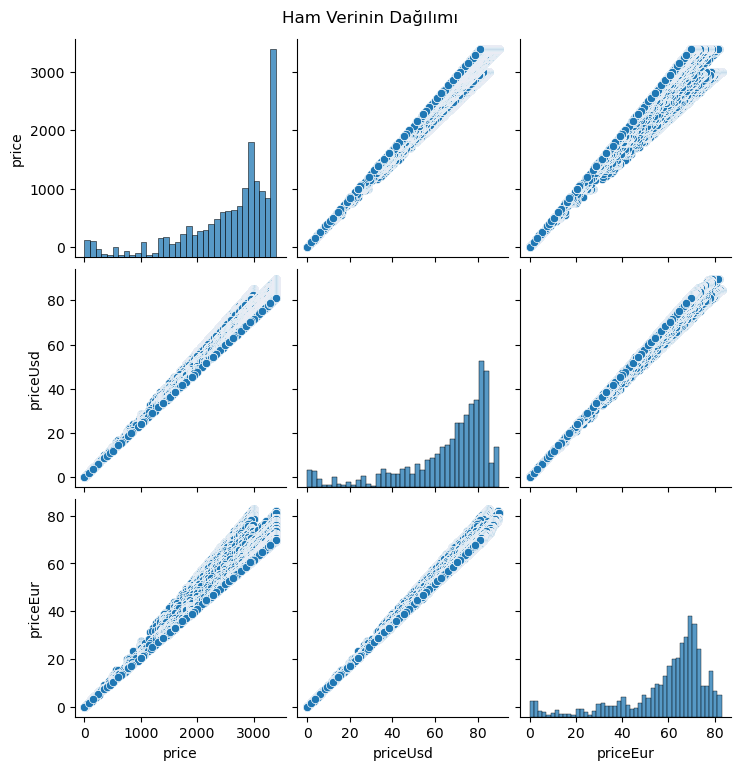

In [91]:
sns.pairplot(df[["price","priceUsd","priceEur"]].dropna())
plt.suptitle("Ham Verinin Dağılımı", y=1.02)
plt.show()

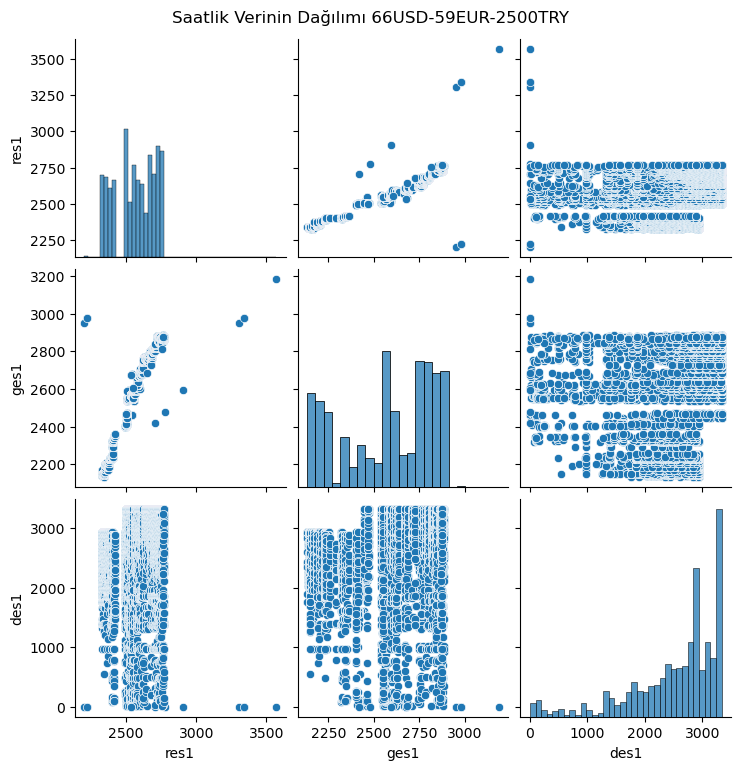

In [92]:
sns.pairplot(df[["res1","ges1","des1"]].dropna())
plt.suptitle("Saatlik Verinin Dağılımı 66USD-59EUR-2500TRY", y=1.02)
plt.show()

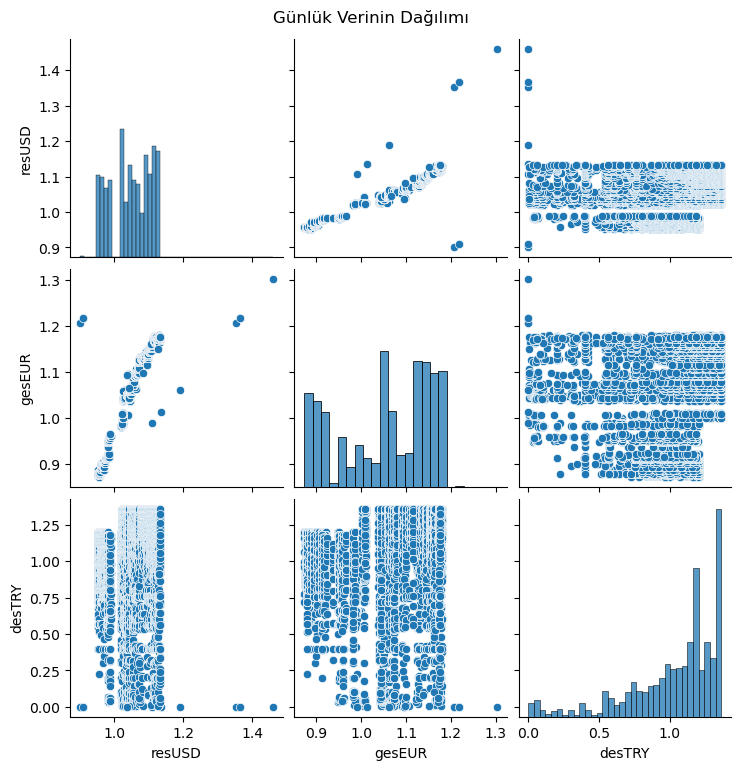

In [93]:
sns.pairplot(dfdaily[["resUSD","gesEUR","desTRY"]].dropna())
plt.suptitle("Günlük Verinin Dağılımı", y=1.02)
plt.show()

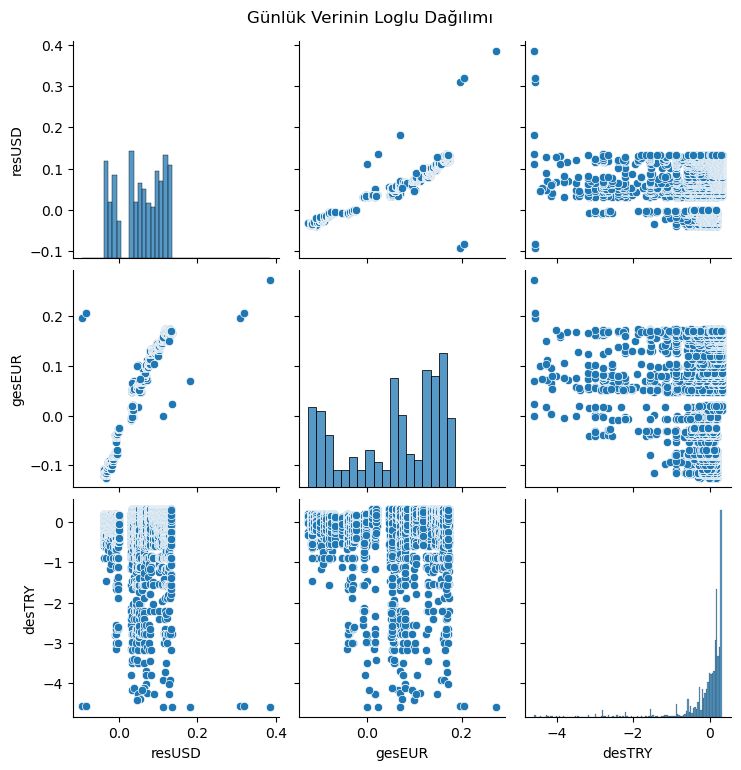

In [94]:
sns.pairplot(dflogdaily[["resUSD","gesEUR","desTRY"]].dropna())
plt.suptitle("Günlük Verinin Loglu Dağılımı", y=1.02)
plt.show()

Yukarıdaki istatistiksel testlerde de görüleceği üzere veri normal dağılıma sahip değildir. 
Bu durumun tam belirlenmesi adına aşağıdaki testler uygulanmıştır. 
 - Q-Q diyagramının çıkarılması
 - P testi
 - Skewness testi
 - Kurtosis testi

Sonuçlar analiz edildiğinde verinin normal olmadığı ispatlanmış oldu. 

C:\Users\gulis\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7230.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro p-value = 5.077458826663798e-59
Skewness = -0.53476416802648
Kurtosis = -1.1393145399832956


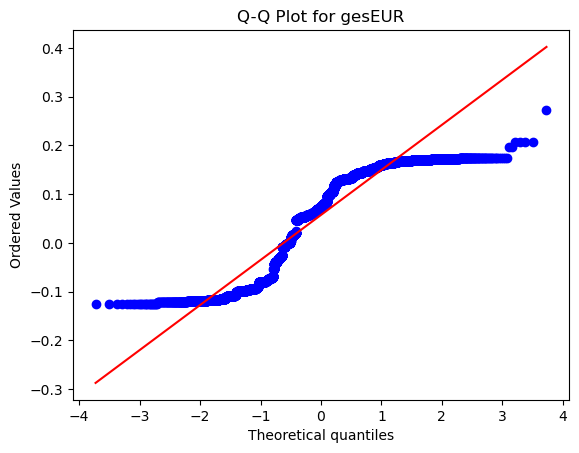

In [98]:
data = dflogdaily["gesEUR"].dropna().values

# --- Shapiro Test ---
stat, p = shapiro(data)
print("Shapiro p-value =", p)        # p < 0.05 ise normal dağılım değil.
print("Skewness =", skew(data))      # çarpıklık 0'a yakın normal
print("Kurtosis =", kurtosis(data))  # basıklık 0'a yakın normal

# --- Q-Q Plot ---
st.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot for gesEUR")
plt.show()                           # Veri lineer bir çizgide olmalı

- Çarpıklık -> Sağ çarpık (right skew)
- Kuyruk -> Sağ kuyruk aşırı kalın (heavy tail)
- Dağılım tipi -> Normal değil
- Muhtemel dağılım -> Lognormal, Gamma, Student-t

C:\Users\gulis\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7230.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro p-value = 3.1972765685110247e-50
Skewness = -0.23226805221146868
Kurtosis = -0.8279183202042097


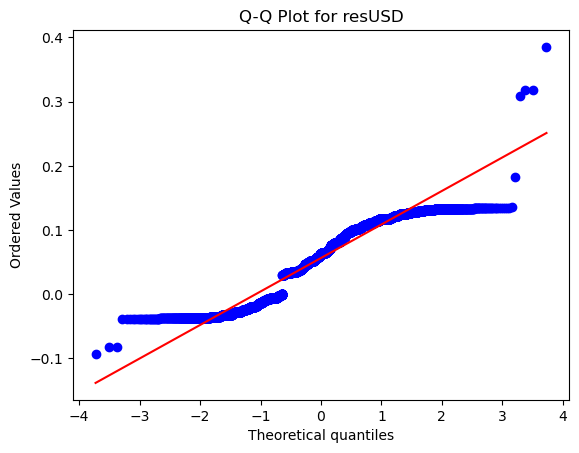

In [95]:
data = dflogdaily["resUSD"].dropna().values

# --- Shapiro Test ---
stat, p = shapiro(data)
print("Shapiro p-value =", p)        # p < 0.05 ise normal dağılım değil.
print("Skewness =", skew(data))      # çarpıklık 0'a yakın normal
print("Kurtosis =", kurtosis(data))  # basıklık 0'a yakın normal

# --- Q-Q Plot ---
st.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot for resUSD")
plt.show()                           # Veri lineer bir çizgide olmalı

- Çarpıklık	-> Sağ çarpık
- Kuyruk	-> Sağ kuyruk çok kalın
- Uygun dağılım -> 	lognormal, gamma, student-t
- Normal dağılım?	->  hayır

C:\Users\gulis\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7272.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro p-value = 5.629513568173988e-88
Skewness = -3.9126109120659907
Kurtosis = 17.517970241152053


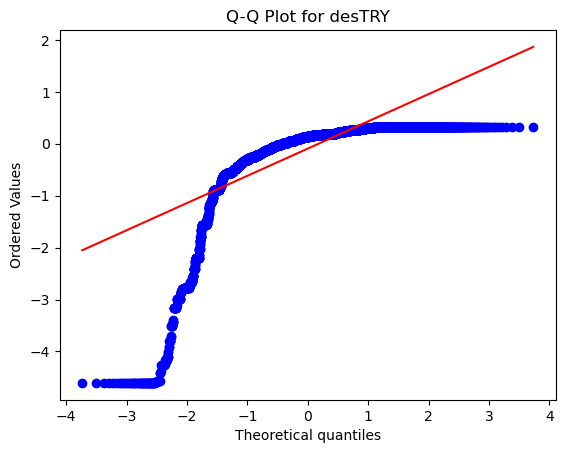

In [101]:
data = dflogdaily["desTRY"].dropna().values

# --- Shapiro Test ---
stat, p = shapiro(data)
print("Shapiro p-value =", p)        # p < 0.05 ise normal dağılım değil.
print("Skewness =", skew(data))      # çarpıklık 0'a yakın normal
print("Kurtosis =", kurtosis(data))  # basıklık 0'a yakın normal

# --- Q-Q Plot ---
st.probplot(data, dist="norm", plot=plt)
plt.title("Q-Q Plot for desTRY")
plt.show()                           # Veri lineer bir çizgide olmalı

Enerji risk yönetimi için:
- Bu tür dağılımlarda CVaR mutlaka kullanılmalıdır
- Mean-variance modeli tail riskini tamamen gözden kaçırır
- Varyans düşük gözükür ama gerçek risk devasa çıkar
DesTRY → “tail-risk bombası”.
Bu grafik, enerji portföyünde des kaynaklarının ağırlığını direkt düşürmen gerektiğini işaret eder (özellikle risk toleransı yüksek değilse).

In [104]:
def classify_distribution(data):
    s = skew(data)
    k = kurtosis(data)   # excess kurtosis (0 = normal)

    print(f"Skewness  = {s:.3f}")
    print(f"Kurtosis  = {k:.3f}")

    # --- Normal dağılım ---
    if abs(s) < 0.5 and abs(k) < 0.5:
        return "Normal veya Normal'e yakın"

    # --- Lognormal (sağa çarpık & ağır kuyruk) ---
    if s > 1 and k > 1:
        return "Lognormal veya sağ heavy-tail (positively skewed)"

    # --- Student-t heavy tail ---
    if abs(s) < 0.5 and k > 3:
        return "Student-t veya simetrik heavy-tail"

    # --- Gamma dağılımı ---
    if 0.5 < s < 3 and 0 < k < 5:
        return "Gamma dağılımı (sağ ağır kuyruk)"

    # --- Exponential dağılım ---
    if s > 1 and 0 < k < 2:
        return "Exponential (hafif sağ kuyruk)"

    # --- Pareto (çok ağır kuyruk) ---
    if s > 2 and k > 10:
        return "Pareto veya aşırı heavy-tail"

    # --- Logistic (orta kuyruk) ---
    if abs(s) < 0.5 and 1 < k < 3:
        return "Logistic (orta kuyruk)"

    # --- Uniform (basıklık negatif) ---
    if k < -0.5:
        return "Uniform veya çok düz dağılım"

    # --- Bimodal (iki tepe) ---
    # ipucu: skewness düşük olabilir ama kurtosis pozitif + QQ-plot S-curve
    if abs(s) < 1 and k > 1:
        return "Bimodal veya karışık dağılım"

    # --- Default fallback ---
    return "Karma / sınıflandırılamayan (mixture?)"

In [106]:
data = dfdaily["resUSD"].dropna().values
print("res" , classify_distribution(data))
data = dfdaily["gesEUR"].dropna().values
print("ges" , classify_distribution(data))
data = dfdaily["desTRY"].dropna().values
print("des" ,classify_distribution(data))

Skewness  = -0.132
Kurtosis  = -0.540
res Uniform veya çok düz dağılım
Skewness  = -0.450
Kurtosis  = -1.215
ges Uniform veya çok düz dağılım
Skewness  = -1.352
Kurtosis  = 1.393
des Karma / sınıflandırılamayan (mixture?)


In [73]:
def optimalPortfolio(df: pd.DataFrame, C: float, gamma: float) -> Tuple[pd.Series, float, float]:
    """
    Interior mean–variance optimizer for procurement weights λ under:
        min_{λ}  C μ^T λ + γ C^2 λ^T Σ λ   s.t.  1^T λ = 1

    Parameters
    ----------
    df : pd.DataFrame
        Historical unit prices (not returns): rows = time, columns = instruments.
        NaNs are dropped row-wise before estimation.
    C : float
        Deterministic total energy requirement (> 0).
    gamma : float
        Risk aversion parameter on variance term (> 0).

    Returns
    -------
    np.ndarray
        The interior optimal weight vector λ* (length = number of columns in df).

    Notes
    -----
    - This returns the *interior* solution, which requires Σ ≻ 0 (SPD).
      If Σ is singular (e.g. a riskless/constant-price instrument or perfect collinearity),
      a ValueError is raised. In that case, remove/merge collinear sources or solve
      the full KKT system with inequality constraints as appropriate.
    - Uses a Cholesky factorization; no explicit matrix inverses are formed.
    """

    #Girdilerden kaynaklı anlamsız hataları verir
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame of historical unit prices.")
    if C <= 0:
        raise ValueError("C must be strictly positive.")
    if gamma <= 0:
        raise ValueError("gamma must be strictly positive.")


    # Nan varsa düşürür ve cov için en az iki satıra ihtiyaç var. 
    df_clean = df.dropna(how="any").astype(float)
    if df_clean.shape[0] < 2 or df_clean.shape[1] < 1:
        raise ValueError("Not enough data after dropping NaNs to estimate μ and Σ.")
    

    mu = df_clean.mean(axis=0).to_numpy()                 # E[p] 
    Sigma = df_clean.cov().to_numpy()                     # Cov[p], ddof=1 by default
    Sigma = 0.5 * (Sigma + Sigma.T)                       # Symmetrize to dampen numerical asymmetry
    n = Sigma.shape[0]                                    # cov boyutu bulundu
    ones = np.ones(n)                                     # Birim vektör (cov boyutunda)

    # Cholesky-based solves to avoid explicit inversion ----- Bu blok, Σ’nın sağlıklı olduğunu garanti altına alıyor
    try:
        cF = cho_factor(Sigma, lower=True, check_finite=True)
    except LinAlgError as e:
        raise ValueError("Covariance matrix Σ is not SPD; interior solution undefined.") from e

    # Solve Σ x = 1 and Σ y = μ
    Sigma_inv_1 = cho_solve(cF, ones)                    #Σ^{−1} * 1
    Sigma_inv_mu = cho_solve(cF, mu)                     #Σ^{−1} * μ

    denom = float(ones @ Sigma_inv_1)                    # 1^T * Σ^{-1} * 1
    if denom <= 0 or not np.isfinite(denom):
        raise ValueError("Numerical issue: 1^T Σ^{-1} 1 must be positive and finite.")

    eta_num = 2.0 * gamma * (C**2) + C * float(ones @ Sigma_inv_mu)    # 2γC^{2} + C1^{⊤}Σ^{−1}μ
    eta = eta_num / denom                                              # [ 2γC^{2} + C1^{⊤}Σ^{−1}μ ] / [ 1^T * Σ^{-1} * 1] 

    # λ* = (1/(2 γ C^2)) [ Σ^{-1}(η 1 - C μ) ] = (1/(2 γ C^2)) (η Σ^{-1}1 - C Σ^{-1}μ)
    lam = (eta * Sigma_inv_1 - C * Sigma_inv_mu) / (2.0 * gamma * (C**2))
    # lam = (C * Sigma_inv_mu - eta * Sigma_inv_1) / (2.0 * gamma * (C**2))

    
    # Optional: enforce the affine constraint numerically (tiny adjustment)
    lam += (1.0 - lam.sum()) * (Sigma_inv_1 / denom)                   # 1^{⊤} * λ = 1 kısıtını mikro ayarla geri oturtur düzeltme amaçlıdır.

    w = pd.DataFrame(lam, index=df.columns )
    E = C * float(mu @ lam)
    V = (C**2) * float(lam @ Sigma @ lam)
    
    return w, E, V 

In [351]:
def optimalPortfoliononshort(
    df: pd.DataFrame,
    C: float,
    gamma: float,
    lower_bounds: Union[float, Sequence[float]] = 0.0,
    upper_bounds: Union[float, Sequence[float]] = 1.0,
    ridge: float = 1e-8,
) -> Tuple[pd.Series, float, float]:
    """
    Solve:  min_λ  C μ^T λ + γ C^2 λ^T Σ λ
            s.t.   1^T λ = 1,  lb ≤ λ ≤ ub
    df: price levels (rows=time, cols=sources). Returns (λ*, E[X], Var[X]).
    """
    if C <= 0 or gamma <= 0:
        raise ValueError("C and gamma must be > 0.")                              # risk katsayısı ve C >0 olmalı
    X = df.dropna(axis=1, how="all").dropna(axis=0, how="any").astype(float)      # Nan lar atılır
    if X.shape[0] < 2 or X.shape[1] < 1:
        raise ValueError("Not enough data.")                                      # Cov için boyutu minumum 2x2 olmalıdır

    mu = X.mean().to_numpy()                                                      # E[p]
    Sigma = X.cov(ddof=1).to_numpy()                                              # Cov[p], ddof=1 by default
    Sigma = 0.5 * (Sigma + Sigma.T) + ridge * np.eye(len(mu))                     # Symmetrize to dampen numerical asymmetry
    n = len(mu)                                                                   # mu boyutu bulundu

    # expand bounds to vectors
    lb = np.full(n, lower_bounds if np.isscalar(lower_bounds) else np.asarray(lower_bounds, float))  #lower bound
    ub = np.full(n, upper_bounds if np.isscalar(upper_bounds) else np.asarray(upper_bounds, float))  #Upper bound
    if lb.sum() > 1 + 1e-12 or ub.sum() < 1 - 1e-12:
        raise ValueError("Infeasible bounds: need sum(lb) ≤ 1 ≤ sum(ub).")                           #sum(lb) ≤ 1 ≤ sum(ub) şartını manuel test ediyor

    # feasible start: begin at lb, spread remaining mass toward ub
    w0 = lb.copy()                                         # ilk olarak ağırlıklar minimuma eşitleniyor
    rem = 1.0 - w0.sum()                                   # Eşitlik koşulundan yola çıkarak 1'den çıkarılıyor
    if rem > 0:                                            # Ağırlıklar bulunur
        room = np.maximum(ub - w0, 0.0)
        total = room.sum()
        if total > 0: w0 += rem * (room / total)           # toplamın 1 e eşit olduğu sağlanır
    w0 = np.clip(w0, lb, ub)                               # ağırlıkları (w) sınırlar içinde burakır

    def fun(w):  return C * mu @ w + gamma * (C**2) * (w @ Sigma @ w)  #fonksiyon f(w)=Cμ⊤w+γC2w⊤Σw amaç fonk  scaler
    def jac(w):  return C * mu + 2.0 * gamma * (C**2) * (Sigma @ w)    #jacobien  ∇f(w)=Cμ+2γC2Σw   1. Türev   (n,)
    def hess(w): return 2.0 * gamma * (C**2) * Sigma                   #hessian   ∇2f(w)=2γC2Σ      2. Türev   (n,n)

    cons = [LinearConstraint(np.ones((1, n)), 1.0, 1.0)]                # w vektörü ve sınırlar toplamlar 1 e eşit
    bnds = Bounds(lb, ub)                                               # Sınırlar 
    opt  = minimize(fun, w0, method="trust-constr", jac=jac, hess=hess, # Optimizasyon tam olarak burda yapılır ve newton tabanlıdır.
                   bounds=bnds, constraints=cons,
                   options={"maxiter": 500, "gtol": 1e-10, "xtol": 1e-12, "verbose": 0})  
    #gtol=1e-10	Gradyan normu bu değerden küçükse dur.
    #xtol=1e-12	w vektöründeki değişim bu değerden küçükse dur.
    #maxiter=500	Maksimum iterasyon sayısı.
    #verbose=0	Çıktı susturulmuş. 2 yapsan her adımı loglar.
    
    if not opt.success:
        raise RuntimeError(f"Optimization failed: {opt.message}")  # algoritmanın neden durduğunu açıklayan yazı "opt.***" gibi türev bilgi verilebilir.

    w = pd.Series(opt.x, index=X.columns, name="λ*")
    E = C * float(mu @ opt.x)
    V = (C**2) * float(opt.x.T @ Sigma @ opt.x)
    return w, E, V

C ve gamma'nın sıfırdan büyük olması şarttır. İki fonksiyonda da (sort ve nonshort) bu kısıtlar mevcuttur. 

- C > 0 olmak zorundadır. Talebin sıfır ve daha küçük olması anlamsızdır.
- gamma > 0 olmak zorundadır.
  * gamma riskten kaçınma katsayısıdır.
  * gamma = 0 olursa E[R] minimize olur.
  * gamma < 0 olursa risk sever bir durum olmakla birlikte varyansı maksimize etmeye iter ve problem ekonomik olarak anlamsızlaşabilir. 
  

In [352]:
prices = df[['res','tes','des','ges']].dropna()
#prices = df2.dropna()
C=10000
gamma= 1.00  #risk katsayısı
n = prices.shape[1]                                    # cov boyutu bulundu
upper_bounds = np.ones(n)   

w, E, V = optimalPortfoliononshort(prices, C=C, gamma=gamma,  upper_bounds=upper_bounds)
print("non sort position")
print(w.round(6))
print(f"Expected cost: {E:,.2f}  |  Variance: {V:,.2f}")

print("with sort position")
w1, E1, V1 =  optimalPortfolio(prices,C,gamma)
print(w1.round(6))
print(f"Expected cost: {E1:,.2f}  |  Variance: {V1:,.2f}")

rf = E * 1.08                              # % 8 faizle bunu yapmaya çalışsın. 
print(f"Referans Fiyat: {rf:,.2f}")

non sort position
res    0.017045
tes    0.136921
des    0.045760
ges    0.800274
Name: λ*, dtype: float64
Expected cost: 8,414.21  |  Variance: 1,004,611.03
with sort position
            0
res  0.017038
tes  0.136921
des  0.045760
ges  0.800281
Expected cost: 8,414.11  |  Variance: 1,004,610.46
Referans Fiyat: 9,087.34


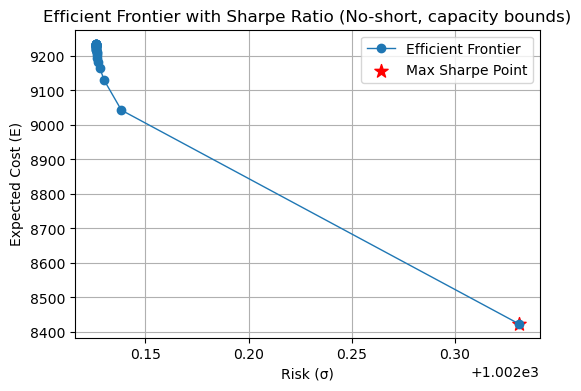

🔹 Best Sharpe Ratio = -8.4041
   γ = 1.0000
   Expected Cost (E) = 8,423.70
   Risk (σ) = 1,002.33
   Normalde TL  = 7,701.16


In [353]:
gammas = np.linspace(1, 90 , 30)  # 1e 106 ... 1e-3 arası 40 nokta

E_list, S_list , Sharpe_list = [], [], []

for g in gammas:
    w, E, V = optimalPortfoliononshort(prices, C=C, gamma=g,
                                       lower_bounds=0.0, upper_bounds=upper_bounds, ridge=1e-6)  
    sigma = np.sqrt(V)              # Risk (standart sapma)
    sharpe = -E / sigma              # Sharpe oranı: S = E / σ
    E_list.append(E)
    S_list.append(sigma)
    Sharpe_list.append(sharpe)

# --- En yüksek Sharpe oranlı nokta ---
idx_max = np.argmax(Sharpe_list)
best_sigma = S_list[idx_max]
best_E = E_list[idx_max]
best_gamma = gammas[idx_max]
best_sharpe = Sharpe_list[idx_max]  #Hocanın istediği tanjantın eğimi


plt.figure(figsize=(6,4))
plt.plot(S_list, E_list, marker='o', linewidth=1, label="Efficient Frontier")
plt.scatter(best_sigma, best_E, color='red', s = 100, marker='*', label='Max Sharpe Point')
plt.xlabel("Risk (σ)")
plt.ylabel("Expected Cost (E)")
plt.title("Efficient Frontier with Sharpe Ratio (No-short, capacity bounds)")
plt.legend()
plt.grid(True)
plt.ticklabel_format(axis='y' , style='plain', useOffset=False)
plt.ticklabel_format(axis='x' , style='sci', useOffset=True)
plt.show()

print(f"🔹 Best Sharpe Ratio = {best_sharpe:,.4f}")
print(f"   γ = {best_gamma:.4f}")
print(f"   Expected Cost (E) = {best_E:,.2f}")
print(f"   Risk (σ) = {best_sigma:,.2f}")
print(f"   Normalde TL  = {norm* C:,.2f}")

nonshort = pd.DataFrame({'E ns': E_list, 'Sigma ns': S_list, 'Sharpe ns': Sharpe_list ,'gamma ns': gammas  })

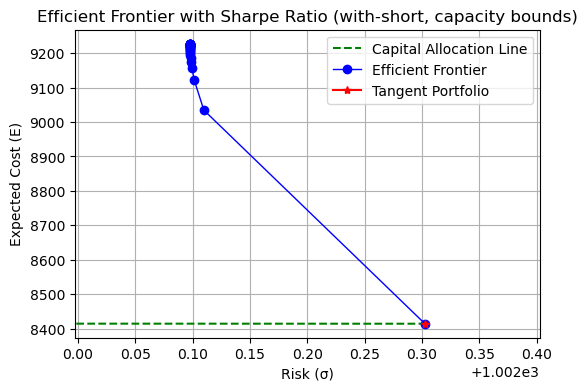

🔹 Best Sharpe Ratio = -8.3948
   γ = 1.0e+00
   Expected Cost (E) = 8,414.11
   Risk (σ) = 1,002.30
   Normalde TL  = 7,701.16


In [354]:
gammas = np.linspace(1, 90 , 30)  # 1e 106 ... 1e-3 arası 40 nokta

E_list, S_list , Sharpe_list = [], [], []

for g in gammas:
    w, E, V = optimalPortfolio(prices, C=C, gamma=g )
    sigma = np.sqrt(V)              # Risk (standart sapma)
    sharpe = -E / sigma              # Sharpe oranı: S = E / σ
    E_list.append(E)
    S_list.append(sigma)
    Sharpe_list.append(sharpe)

# --- En yüksek Sharpe oranlı nokta ---
idx_max = np.argmax(Sharpe_list)
best_sigma = S_list[idx_max]
best_E = E_list[idx_max]
best_gamma = gammas[idx_max]
best_sharpe = Sharpe_list[idx_max]

#rf = norm * C
#sigma_line = np.linspace(1, max(S_list)*1.1, 10)
#E_line = rf + best_sharpe * sigma_line

plt.figure(figsize=(6,4))

# Capital Allocation Line (rf'den tanjant noktaya)
xline = np.linspace(0, max(S_list), 30)
yline = rf + (best_E - rf) / np.array(S_list) * xline
plt.plot(xline, yline, ls='--', color='green' , label="Capital Allocation Line")
plt.xlim([min(S_list)*0.9999, max(S_list)*1.0001])
plt.plot(S_list, E_list, marker='o',  color='blue' , linewidth=1, label="Efficient Frontier")
plt.plot(best_sigma, best_E, color='red',  marker='*', label='Tangent Portfolio')
plt.xlabel("Risk (σ)")
plt.ylabel("Expected Cost (E)")
plt.ticklabel_format(style='plain', axis='both')
plt.title("Efficient Frontier with Sharpe Ratio (with-short, capacity bounds)")
plt.legend()
plt.grid(True)
plt.ticklabel_format(axis='y' , style='plain', useOffset=False)
plt.ticklabel_format(axis='x' , style='sci', useOffset=True)
plt.show()

print(f"🔹 Best Sharpe Ratio = {best_sharpe:,.4f}")
print(f"   γ = {best_gamma:.1e}")
print(f"   Expected Cost (E) = {best_E:,.2f}")
print(f"   Risk (σ) = {best_sigma:,.2f}")
print(f"   Normalde TL  = {rf:,.2f}")

withshort = pd.DataFrame({'E ws': E_list, 'Sigma ws': S_list, 'Sharpe ws': Sharpe_list ,'gamma ws': gammas  })

Türetilen veriler yani elektrik fiyatı verileri, bir birinden türetilen veriler olduğu için genellikle seçilen portföyde 1 seçeneğe çok yüksek lamda çıkıyor. Buda varyansı düşük olan seçenektir. Gamma radikal değişse bile E ve Sigma neredeyse mikro boyutta değişmektedir. Bu sebeple verilerle oynanmış ve dolar bazlı olan sütun bir çarpanla çarpılmıştır. 

In [356]:
#------------------------------
#Birinci Türevın Max olduğu nokta bulundu. Sharpe ile aynı olduğu teyir edildi. 
#------------------------------
data = pd.concat([withshort,nonshort], axis=1  )
interview = np.linspace(1, 30 , 30)

derivative_list = []
for i in range(len(interview)-1):
    derivative = (data["E ws"][i+1] - data["E ws"][i]) / (data["Sigma ws"][i+1] - data["Sigma ws"][i])
    derivative_list.append(derivative)
idx_max = np.argmin(derivative_list) +1 


-----------------------------------------------------------------------------------------------
Sharpe Oranı tanjant alfayı vermektedir. En iyi sharpe oranı en yüksek olanıdır. Çünkü risk başına beklenen gelir daha yüksek olacaktır. 

* E = Rf + S ⋅ σ

E  portföyün beklenen getirisi
Rf risksiz getiri (saatlik fiyat * C = norm)
σ portföyün riski
S Sharpe oranı (tanjantın eğimi)

* S = (E - RF) / σ

Monte Carlo Simulation 

In [381]:
mu    = prices.mean().to_numpy()                                                      # E[p]
Sigma = prices.cov(ddof=1).to_numpy()      
C = C
λ = w1 #non -short
λ = w  #with short 

# 10.000 senaryo simülasyonu
n_sim = 10_000
p = np.random.multivariate_normal(mu, Sigma, n_sim)   # ortalama maliyet üretildi. Rastgele ama mantıklı. 


# Toplam maliyet
X = C * p @ λ

# İstatistikler


mean_cost = X.values.mean()
std_dev   = X.values.var() **0.5
print(f"Beklenen Maliyet: {mean_cost:.2f}, Varyans: {std_dev:.2f}")


Beklenen Maliyet: 9215.90, Varyans: 1010.74


In [377]:
mean_cost

np.float64(9228.096027049962)